In [9]:
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, GlobalAveragePooling2D
from keras.layers import  Flatten, Reshape, Concatenate, Activation, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LambdaCallback
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.applications.mobilenet import _depthwise_conv_block, _conv_block

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
# from moviepy.editor import VideoFileClip
import numpy as np
import pandas as pd
import cv2
import glob

In [2]:
train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

# Training dataset
train_images_dir      = 'udacity_driving_datasets/'
train_labels_filename = 'udacity_driving_datasets/train_labels.csv'

# Validation dataset
val_images_dir      = 'udacity_driving_datasets/'
val_labels_filename = 'udacity_driving_datasets/val_labels.csv'

train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=val_images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

In [32]:
def mobilenet_model(image_shape, n_classes, input_shape=(128,128,3), l2_reg=0.0, 
                    scales = [0.08, 0.16, 0.32, 0.64, 0.96],
                  variances = np.array([1.0, 1.0, 1.0, 1.0]),
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]]):
    n_predictor_layers = 4 # The number of predictor conv layers in the network
    n_classes += 1 # Account for the background class.
    # one box per aspect ratio, so for a predictor layer with 3 ratios then 3 boxes
    n_boxes = []
    scales = scales # for anchor boxes 
    variances = variances
    steps = [None] * n_predictor_layers
    offsets = [None] * n_predictor_layers
    
    for i in aspect_ratios_per_layer:
        n_boxes.append(len(i))
        
    alpha=1.0
    depth_multiplier=1
    dropout=1e-3
    
    img_height = input_shape[0]
    img_width = input_shape[1]
        
    x = Input(shape=image_shape)
    x1 = Lambda(lambda x: K.tf.image.resize_images(x, (input_shape[0], input_shape[1])))(x)
    x1 = Lambda(lambda x: x - np.array(127.5), output_shape=input_shape,
                   name='input_mean_norm')(x)
    x1 = Lambda(lambda x: x/np.array(127.5), output_shape=input_shape,
                   name='input_scaler')(x1)
    
    conv = _conv_block(x1, 32, alpha, strides=(2, 2))
    d1 = _depthwise_conv_block(conv, 64, alpha, depth_multiplier, block_id=1)

    d2 = _depthwise_conv_block(d1, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    d3 = _depthwise_conv_block(d2, 128, alpha, depth_multiplier, block_id=3)

    d4 = _depthwise_conv_block(d3, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    d5 = _depthwise_conv_block(d4, 256, alpha, depth_multiplier, block_id=5)

    d6 = _depthwise_conv_block(d5, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    d7 = _depthwise_conv_block(d6, 512, alpha, depth_multiplier, block_id=7)
    d8 = _depthwise_conv_block(d7, 512, alpha, depth_multiplier, block_id=8)
    d9 = _depthwise_conv_block(d8, 512, alpha, depth_multiplier, block_id=9)
    d10 = _depthwise_conv_block(d9, 512, alpha, depth_multiplier, block_id=10)
    d11 = _depthwise_conv_block(d10, 512, alpha, depth_multiplier, block_id=11)

    d12 = _depthwise_conv_block(d11, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    d13 = _depthwise_conv_block(d12, 1024, alpha, depth_multiplier, block_id=13)
    
    
    classes4 = Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes4')(d10)
    classes5 = Conv2D(n_boxes[1] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes5')(d11)
    classes6 = Conv2D(n_boxes[2] * n_classes, (3, 3), strides=(1, 1), 
                      padding="same", kernel_initializer='glorot_normal', 
                      kernel_regularizer=l2(l2_reg), name='classes6')(d12)
    classes7 = Conv2D(n_boxes[3] * n_classes, (3, 3), strides=(1, 1), padding="same", 
                      kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                      name='classes7')(d13)
    
    
    # 4 coords per box -- xmin, xmax, ymun, ymax
    box4 = Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box4')(d10)
    box5 = Conv2D(n_boxes[1] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box5')(d11)
    box6 = Conv2D(n_boxes[2] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box6')(d12)
    box7 = Conv2D(n_boxes[3] * 4, (3, 3), strides=(1, 1), padding="same", 
                  kernel_initializer='glorot_normal', kernel_regularizer=l2(l2_reg), 
                  name='box7')(d13)
    
    
    #use the custom anchorbox layer to generate predictions for boxes
    anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios_per_layer[0],
                           two_boxes_for_ar1=False, this_steps=steps[0], this_offsets=offsets[0],
                           limit_boxes=False, variances=variances, coords='centroids', 
                           normalize_coords=False, name='anchors4')(box4)
    anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios_per_layer[1],
                           two_boxes_for_ar1=False, this_steps=steps[1], this_offsets=offsets[1],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors5')(box5)
    anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios_per_layer[2],
                           two_boxes_for_ar1=False, this_steps=steps[2], this_offsets=offsets[2],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors6')(box6)
    anchors7 = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios_per_layer[3],
                           two_boxes_for_ar1=False, this_steps=steps[3], this_offsets=offsets[3],
                           limit_boxes=False, variances=variances, coords='centroids', normalize_coords=False, name='anchors7')(box7)
    
    
    # Reshape the class predictors tensor into (batch, height * width * n_boxes, n_classes) => the class is now the last variable for predcition
    classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
    classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
    classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)
    classes7_reshaped = Reshape((-1, n_classes), name='classes7_reshape')(classes7)
    
    # Reshape the box coords predictions, into tensors of shape (batch, height * width * n_boxes, 4) => box positions last for loss
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(box4)
    boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(box5)
    boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(box6)
    boxes7_reshaped = Reshape((-1, 4), name='boxes7_reshape')(box7)
    # Reshape the anchor box tensors, into tensors of shape (batch, height * width * n_boxes, 8)
    anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
    anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
    anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)
    anchors7_reshaped = Reshape((-1, 8), name='anchors7_reshape')(anchors7)
    #concat along the middle axis, since want to keep the batch and n_classes/8 untouched
    class_concat = Concatenate(axis=1, name='concatenate_classes')([classes4_reshaped, 
                                classes5_reshaped,classes6_reshaped, 
                                classes7_reshaped])
    boxes_concat = Concatenate(axis=1, name='concatenate_boxes')([boxes4_reshaped,
                                                             boxes5_reshaped,
                                                             boxes6_reshaped,
                                                             boxes7_reshaped])

    # Output shape of `anchors_final`: (batch, n_boxes_total, 8)
    anchors_concat = Concatenate(axis=1, name='concatenate_anchors')([anchors4_reshaped,
                                                                 anchors5_reshaped,
                                                                 anchors6_reshaped,
                                                                 anchors7_reshaped])
    
#     classification_softmax = Activation('softmax', name='classes_softamx')(class_concat)
    classes_softmax = Activation('softmax', name='classes_softmax')(class_concat)
    
    prediction = Concatenate(axis=2,name='concatenate_output')([
#         class_concat,
                                                            classes_softmax,
                                                              boxes_concat,
                                                              anchors_concat ])
    
    model = Model(inputs=x, outputs=prediction)
    
    return model

In [33]:
K.clear_session() # Clear previous models from memory.

model = mobilenet_model((300, 480, 3), 5, input_shape=(300,480,3), l2_reg=0.005, 
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]])

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

# with negative hard mining
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)



In [27]:
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]
ssd_box_encoder = SSDBoxEncoder(img_height=300,
                                img_width=480,
                                n_classes=5, 
                                predictor_sizes=predictor_sizes,
                                scales=[0.08, 0.16, 0.32, 0.64, 0.96],
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                                two_boxes_for_ar1=False,
                                steps=None,
                                offsets=None,
                                limit_boxes=False,
                                variances=[1.,1.,1.,1.],
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords='centroids',
                                normalize_coords=True)

In [28]:
batch_size = 32 # Change the batch size if you like, or if you run into memory issues with your GPU.

# 5: Set the image processing / data augmentation options and create generator handles.

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=0.5, # Randomly flip horizontally with probability 0.5
                                         translate=((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     random_pad_and_resize=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4)

# Get the number of samples in the training and validations datasets to compute the epoch lengths below.
n_train_samples = train_dataset.get_n_samples()
n_val_samples = val_dataset.get_n_samples()



In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
input_mean_norm (Lambda)        (None, 300, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_scaler (Lambda)           (None, 300, 480, 3)  0           input_mean_norm[0][0]            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 240, 32) 864         input_scaler[0][0]               
__________________________________________________________________________________________________
conv1_bn (

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
input_mean_norm (Lambda)        (None, 300, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_scaler (Lambda)           (None, 300, 480, 3)  0           input_mean_norm[0][0]            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 240, 32) 864         input_scaler[0][0]               
__________________________________________________________________________________________________
conv1_bn (

In [35]:
epochs = 30

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = (n_train_samples//batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd7_train/ssd7_mobilenet_weights_epoch-{epoch:02d}_loss-{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           TensorBoard(log_dir='./logs/ssd_mobilenet1'),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=4),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=2,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = (n_val_samples//batch_size))

# TODO: Set the filename (without the .h5 file extension!) under which to save the model and weights.
#       Do the same in the `ModelCheckpoint` callback above.
model_name = 'ssd7_mobilenet_v1'
model.save('ssd7_train/{}.h5'.format(model_name))
model.save_weights('ssd7_train/{}_weights.h5'.format(model_name))

print()
print("Model saved under ssd7_train/{}.h5".format(model_name))
print("Weights also saved separately under ssd7_train/{}_weights.h5".format(model_name))
print()

Epoch 1/30
556/556 [==============================] - 908s 2s/step - loss: 3.7907 - val_loss: 4.2788
Epoch 2/30
556/556 [==============================] - 792s 1s/step - loss: 2.7202 - val_loss: 2.5253
Epoch 3/30
556/556 [==============================] - 803s 1s/step - loss: 2.2546 - val_loss: 2.1102
Epoch 4/30
556/556 [==============================] - 805s 1s/step - loss: 2.0219 - val_loss: 2.3701
Epoch 5/30
556/556 [==============================] - 804s 1s/step - loss: 1.8353 - val_loss: 1.7374
Epoch 6/30
556/556 [==============================] - 804s 1s/step - loss: 1.7640 - val_loss: 1.6658
Epoch 7/30
556/556 [==============================] - 804s 1s/step - loss: 1.6999 - val_loss: 1.6428
Epoch 8/30
556/556 [==============================] - 805s 1s/step - loss: 1.6491 - val_loss: 1.5666
Epoch 9/30
556/556 [==============================] - 805s 1s/step - loss: 1.6093 - val_loss: 1.5825
Epoch 10/30
556/556 [==============================] - 804s 1s/step - loss: 1.5507 - val_lo

In [36]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         train=False,
                                         returns={'processed_labels',
                                                  'filenames'},
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

In [38]:
X, y_true, filenames = next(predict_generator)
y_pred = model.predict(X)
y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.1,
                           iou_threshold=0.2,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=False,
                           img_height=300,
                           img_width=480)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):\n")
print(y_pred_decoded[0])

Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):

[[   1.      0.99  161.14  140.66  187.1   160.91]
 [   1.      0.96  274.07  138.28  306.57  163.44]
 [   1.      0.68  225.72  139.84  240.1   152.57]
 [   1.      0.66  240.6   139.66  256.93  153.75]]


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

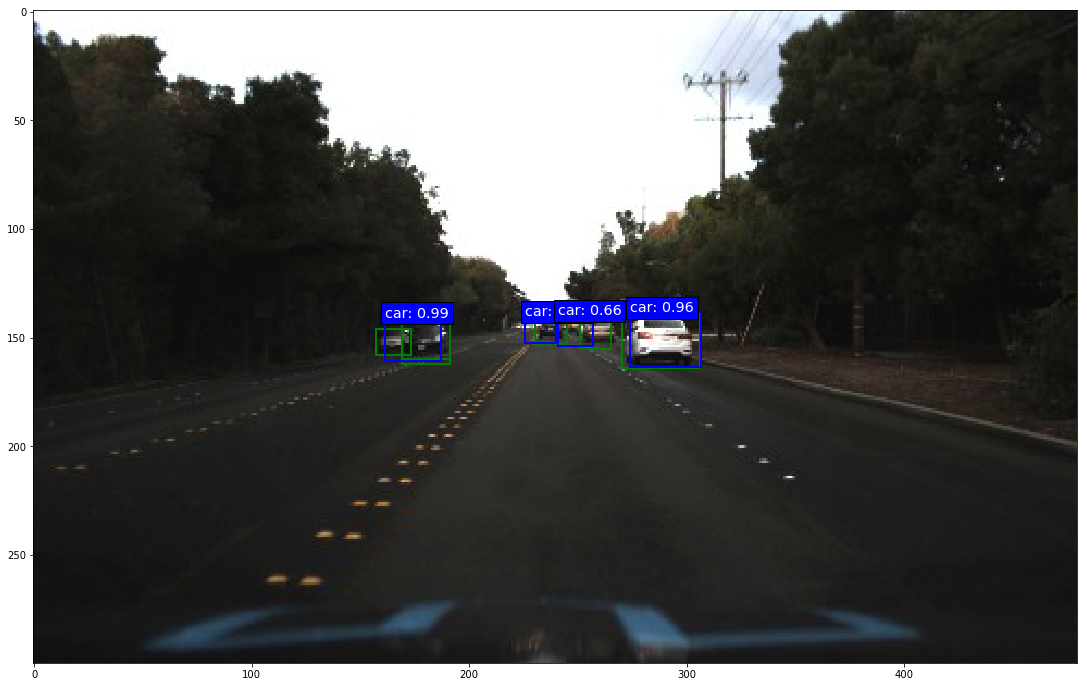

In [44]:
i = 0
plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
#     color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

In [49]:
def pipeline(image):
    
    img_input = cv2.resize(image, (480, 300))

    predict = model.predict(np.array([img_input]))

    image_out = draw_decoded(predict, image)
    return image_out

In [56]:
def draw_decoded(y_predicted, inputImg):
    y_pred_decoded = decode_y2(y_predicted,
                               confidence_thresh=0.1,
                               iou_threshold=0.3,
                               top_k='all',
                               input_coords='centroids',
                               normalize_coords=False,
                               img_height=300,
                               img_width=480)
    #udacity traffic dataset classes
    classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] 
    image = np.copy(inputImg)
    # Draw the predicted boxes in blue:
    #Decoded predictions of boxes (is a list of [class_id, confidence, xmin, ymin, xmax, ymax])
    for box in y_pred_decoded[0]:
        if(box[0] == 1 or box[0] ==2):
        # Transform the predicted bounding boxes for the 300x480 image to the original image dimensions.
            xmin = box[2] * image.shape[1] / 480
            ymin = box[3] * (image.shape[0]) / 300
            xmax = box[4] * image.shape[1] / 480
            ymax = box[5] * (image.shape[0] )/ 300


            cv2.rectangle(image, (np.int(xmin), np.int(ymin) ), (np.int(xmax),np.int(ymax )), (0, 0, 255), 6)
    
    return image

In [57]:
import time
from moviepy.editor import VideoFileClip
video_output = 'ssd7mobilenet_output_test_c-01-i-013.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip_out = clip1.fl_image(pipeline)
%time clip_out.write_videofile(video_output, audio=False, progress_bar=False, verbose=False)

CPU times: user 5min 17s, sys: 24 s, total: 5min 41s
Wall time: 2min 13s
